# LSTM Modelling

In [1]:
# import libraries

import numpy as np
import pandas as pd

In [2]:
#load the labelled data

data = pd.read_csv('./labelled_df.csv')
print(data.shape)

(2476065, 42)


In [3]:
# Count the no. of cases in each class
data['high_net_worth'].value_counts()/data.shape[0]

0    0.833325
1    0.166675
Name: high_net_worth, dtype: float64

In [4]:
data.columns

Index(['betTimestamp', 'odds_units', 'stake_gbp', 'count_legs',
       'hours_to_event', 'betDate', 'edge', 'encrypted_user_no', 'insert_date',
       'riskexposureprematch', 'betTimestamp_diff', 'odds_units_diff',
       'stake_gbp_diff', 'count_legs_diff', 'hours_to_event_diff',
       'riskexposureprematch_diff', 'total_bets', 'avg_riskexposureprematch',
       'avg_odds_units', 'avg_stake_gbp', 'total_stake_gbp', 'month', 'day',
       'day_of_week', 'hour', 'bet_sequence_count', 'total_bets_in_sequence',
       'total_bets_until_now', 'avg_riskexposureprematch_until_now',
       'avg_odds_units_until_now', 'avg_count_legs_until_now',
       'avg_stake_gbp_until_now', 'total_stake_gbp_until_now',
       'std_stake_gbp_until_now', 'bets_in_last_1_week(s)',
       'bets_in_last_2_week(s)', 'bets_in_last_3_week(s)',
       'bets_in_last_4_week(s)', 'num_sequences_until_now',
       'num_bets_in_prev_sequence', 'time_diff_of_riskexposure',
       'high_net_worth'],
      dtype='object'

In [5]:
# Select the features and target variable
features = ['odds_units', 'stake_gbp', 'count_legs', 'hours_to_event',
            'betTimestamp_diff', 'odds_units_diff',
            'stake_gbp_diff', 'count_legs_diff', 'hours_to_event_diff',
            'riskexposureprematch_diff',
       'total_bets_until_now',
       'avg_odds_units_until_now', 'avg_count_legs_until_now',
       'avg_stake_gbp_until_now', 'total_stake_gbp_until_now',
       'std_stake_gbp_until_now','bets_in_last_1_week(s)', 
            'bets_in_last_2_week(s)', 'bets_in_last_3_week(s)', 
            'bets_in_last_4_week(s)']


X = data.loc[:, features]
y = data['high_net_worth'].values

In [6]:
# identify the best training and testing split that 
# minimizes the difference in positive class ratios between the two sets during cross-validation.

from sklearn.model_selection import GroupKFold

group_kfold = GroupKFold(n_splits=5)
group_kfold.get_n_splits(X, y, data['encrypted_user_no'])
for i, (train_index, test_index) in enumerate(group_kfold.split(X, y, data['encrypted_user_no'])):
    if i == 0:
        best_train = train_index
        best_test = test_index
        trp = sum(y[train_index]==1)/len(train_index)
        tep = sum(y[test_index]==1)/len(test_index)
        bdiff = np.abs(trp-tep)
    else:
        trp = sum(y[train_index]==1)/len(train_index)
        tep = sum(y[test_index]==1)/len(test_index)
        tdiff = np.abs(trp-tep)
        if tdiff < bdiff:
            best_train = train_index
            best_test = test_index
            bdiff = tdiff
print(data.loc[best_train,'high_net_worth'].value_counts()/len(best_train))
print(data.loc[best_test,'high_net_worth'].value_counts()/len(best_test))

0    0.830962
1    0.169038
Name: high_net_worth, dtype: float64
0    0.842781
1    0.157219
Name: high_net_worth, dtype: float64


In [7]:
#Split the data for trainining/test

# create seperate arrays to store user_ids to use for model analysis

X_train = X.loc[best_train,:]
y_train = y[best_train]
X_test = X.loc[best_test, :]
y_test = y[best_test]

# # Extracting and saving 'encrypted_user_no' from train and test
# users_train = X_train['encrypted_user_no'].values
# users_test = X_test['encrypted_user_no'].values

# # Dropping 'encrypted_user_no' from X_train and X_test
# X_train = X_train.drop(columns=['encrypted_user_no']).values
# X_test = X_test.drop(columns=['encrypted_user_no']).values

In [8]:
# check users don't appear in both sets
# error raised if there is the same user in test and train
train_users = set(data.loc[best_train, 'encrypted_user_no'])
test_users = set(data.loc[best_test, 'encrypted_user_no'])
common_users = train_users.intersection(test_users)

assert len(common_users) == 0, "There are common users in the training and test sets."


In [9]:
np.isnan(X_train).sum()

odds_units                   0
stake_gbp                    0
count_legs                   0
hours_to_event               0
betTimestamp_diff            0
odds_units_diff              0
stake_gbp_diff               0
count_legs_diff              0
hours_to_event_diff          0
riskexposureprematch_diff    0
total_bets_until_now         0
avg_odds_units_until_now     0
avg_count_legs_until_now     0
avg_stake_gbp_until_now      0
total_stake_gbp_until_now    0
std_stake_gbp_until_now      0
bets_in_last_1_week(s)       0
bets_in_last_2_week(s)       0
bets_in_last_3_week(s)       0
bets_in_last_4_week(s)       0
dtype: int64

In [10]:
# Scale the data by standardising the variables to mean 0 and sd 1

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# #Reshape Train and test data to make them suitable for LSTM

# X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
# X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# LSTM Model with hyperparameter tuning and timestep of 10

### In order to use timesteps of 10, need to adjust the input for X and y. For all sequences of less than 10 bets, i.e a user with less than 10 bets total or a user with a number of bets not divisible by 10, then the specific seqeunce with fewer than 10 bets will be disregarded.

In [7]:
from tqdm import tqdm

from sklearn.impute import SimpleImputer

#Reshape Train and test data to make them suitable for LSTM with timesteps of 10
def generate_sequences(data, sequence_length=10):
    sequences = []
    target_sequences = []
    seq_index=[]
    
    # Group by user and iterate over groups instead of filtering
    sorted_data = data.sort_values(['encrypted_user_no', 'total_bets_until_now'])
    users = sorted_data['encrypted_user_no'].unique()
    
    for user in tqdm(users):
        user_data = sorted_data.loc[sorted_data['encrypted_user_no']==user,features].values
        user_targets = sorted_data.loc[sorted_data['encrypted_user_no']==user,'high_net_worth'].values
        user_indices = sorted_data.index[sorted_data['encrypted_user_no']==user].values
        for i in range(0, len(user_data) - sequence_length + 1):
            seq = user_data[i:i+sequence_length]
            
            # Add only if the sequence has the required length
            if len(seq) == sequence_length:
                sequences.append(seq)
                target_sequences.append(user_targets[i+sequence_length-1])
                seq_index.append(user_indices[i+sequence_length-1])
            
    return np.array(sequences), np.array(target_sequences), seq_index

# Generate sequences for training and test data
X_train_sequences,y_train_sequences, train_seq_index = generate_sequences(data.loc[best_train, :])
X_test_sequences, y_test_sequences, test_seq_index = generate_sequences(data.loc[best_test, :])

# Scale the sequences
X_train_sequences_flat = X_train_sequences.reshape(-1, len(features))
X_test_sequences_flat = X_test_sequences.reshape(-1, len(features))


#Impute the missing data with mean
imputer = SimpleImputer(strategy='mean')
X_train_sequences_flat = imputer.fit_transform(X_train_sequences_flat)

#You cannot impute the missing data using the test data, as that will include bias
#But impute the test data after fitting the imputer with train data
X_test_sequences_flat = imputer.transform (X_test_sequences_flat)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_sequences_flat = scaler.fit_transform(X_train_sequences_flat)
X_test_sequences_flat = scaler.transform(X_test_sequences_flat)

# Reshape them back to sequences
X_train_sequences = X_train_sequences_flat.reshape(-1, 10, len(features))
X_test_sequences = X_test_sequences_flat.reshape(-1, 10, len(features))


100%|██████████| 2968/2968 [03:53<00:00, 12.72it/s]


NameError: name 'StandardScaler' is not defined

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_sequences_flat = scaler.fit_transform(X_train_sequences_flat)
X_test_sequences_flat = scaler.transform(X_test_sequences_flat)

# Reshape them back to sequences
X_train_sequences = X_train_sequences_flat.reshape(-1, 10, len(features))
X_test_sequences = X_test_sequences_flat.reshape(-1, 10, len(features))

In [9]:
print(X_train_sequences.shape)
print(X_test_sequences.shape)

(1879495, 10, 20)
(469853, 10, 20)


In [10]:
print(y_train_sequences.shape)
print(y_test_sequences.shape)

(1879495,)
(469853,)


In [15]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam, RMSprop


n_features = X_train_sequences.shape[2]

# function to build model
def build_model_timesteps(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('lstm_units_1', min_value=64, max_value=128, step=32), input_shape=(10, n_features), return_sequences=True))
    model.add(LSTM(hp.Int('lstm_units_2', min_value=32, max_value=128, step=32), return_sequences=False))
    model.add(Dense(hp.Int('dense_units', min_value=512, max_value=1024, step=128), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    
    if optimizer == 'adam':
        optimizer_instance = Adam(learning_rate=learning_rate)
    else:
        optimizer_instance = RMSprop(learning_rate=learning_rate)

    model.compile(loss='binary_crossentropy', optimizer=optimizer_instance, metrics=['accuracy'])
    
    return model

# search space
tuner_timesteps = RandomSearch(
    build_model_timesteps,
    objective='val_accuracy',
    max_trials=5, # Number of different hyperparameter combinations to try
    executions_per_trial=2, # Number of times to train each model, to average out the metrics
    directory='LSTM_tuning', #rename to 'LSTM_tuning'
    project_name='hnetworth') #change to hnetworth

2023-09-09 20:53:32.872417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-09 20:53:32.879528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-09 20:53:32.881842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [16]:
# perform tuning
from keras.callbacks import EarlyStopping,  ModelCheckpoint
from sklearn.utils import shuffle

# Shuffle the data
X_train_sequences, y_train_sequences = shuffle(X_train_sequences, y_train_sequences, random_state=42)

# Select 5% of the data
sample_size = int(0.1 * len(X_train_sequences))
X_train_subsample = X_train_sequences[:sample_size]
y_train_subsample = y_train_sequences[:sample_size]

filepath = 'best_tuning_LSTM.hdf5' # change to 'best_tuning_LSTM.hdf5'

estopping = EarlyStopping(monitor='val_accuracy', patience=5)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)

tuner_timesteps.search(X_train_subsample, y_train_subsample, epochs=20, batch_size=256, validation_split=0.05, callbacks=[checkpoint, estopping])

Trial 5 Complete [00h 36m 32s]
val_accuracy: 0.9569589197635651

Best val_accuracy So Far: 0.9569589197635651
Total elapsed time: 02h 14m 30s
INFO:tensorflow:Oracle triggered exit


In [17]:
# get best hyperparameters

best_hyperparameters_timesteps = tuner_timesteps.get_best_hyperparameters(num_trials=1)[0]

# Print the full dictionary of hyperparameters
best_hps_values = best_hyperparameters_timesteps.values

for key, value in best_hps_values.items():
    print(f"{key}: {value}")

lstm_units_1: 128
lstm_units_2: 64
dense_units: 640
dropout: 0.1
optimizer: rmsprop
learning_rate: 0.005174671499174863


In [18]:
# obtain the best model
best_model_timesteps = tuner_timesteps.get_best_models(num_models=1)[0]

2023-09-09 23:10:05.578451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-09 23:10:05.580332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-09 23:10:05.581976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [19]:
# Build the model with best hyperparameters
best_LSTM_model = build_model_timesteps(best_hyperparameters_timesteps)

2023-09-09 23:10:06.297701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-09 23:10:06.299568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-09 23:10:06.301055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [20]:
# Train model on entire training dataset
filepath_final = 'LSTM_model_best.hdf5'

checkpoint_final = ModelCheckpoint(filepath_final, monitor='val_accuracy', verbose=1, save_best_only=True)

history_LSTM=best_LSTM_model.fit(X_train_sequences, y_train_sequences, epochs=30, batch_size=256, validation_split=0.1, callbacks=[checkpoint_final,estopping])

Epoch 1/30


2023-09-09 23:10:22.614465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-09 23:10:22.616406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-09 23:10:22.617908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6608/6608 [==============================] - ETA: 0s - loss: 0.1693 - accuracy: 0.9329

2023-09-09 23:19:39.592278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-09 23:19:39.594344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-09 23:19:39.596307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_accuracy improved from -inf to 0.94395, saving model to LSTM_model_best.hdf5
6608/6608 [==============================] - 573s 86ms/step - loss: 0.1693 - accuracy: 0.9329 - val_loss: 0.1427 - val_accuracy: 0.9440
Epoch 2/30
6607/6608 [============================>.] - ETA: 0s - loss: 0.1216 - accuracy: 0.9529
Epoch 2: val_accuracy improved from 0.94395 to 0.95711, saving model to LSTM_model_best.hdf5
6608/6608 [==============================] - 424s 64ms/step - loss: 0.1216 - accuracy: 0.9529 - val_loss: 0.1101 - val_accuracy: 0.9571
Epoch 3/30
6607/6608 [============================>.] - ETA: 0s - loss: 0.1059 - accuracy: 0.9597
Epoch 3: val_accuracy improved from 0.95711 to 0.95982, saving model to LSTM_model_best.hdf5
6608/6608 [==============================] - 412s 62ms/step - loss: 0.1059 - accuracy: 0.9597 - val_loss: 0.1036 - val_accuracy: 0.9598
Epoch 4/30
6607/6608 [============================>.] - ETA: 0s - loss: 0.0958 - accuracy: 0.9639
Epoch 4: val_accuracy

In [21]:
# evaluate the best model on test data
loss_timesteps, accuracy_timesteps = best_LSTM_model.evaluate(X_test_sequences, y_test_sequences)
print("Accuracy on Test Set:", accuracy_timesteps)

14683/14683 [==============================] - 84s 6ms/step - loss: 0.9625 - accuracy: 0.8679
Accuracy on Test Set: 0.8679459095001221


In [ ]:
from tensorflow.keras.models import load_model

best_LSTM_model = load_model('LSTM_model_best.hdf5')

In [22]:
# Evaluate the best model on validation data

from sklearn.metrics import classification_report, accuracy_score

y_prob_timesteps = best_LSTM_model.predict(X_test_sequences)
y_pred_timesteps = (y_prob_timesteps>0.5).astype(int)
accuracy_timesteps = accuracy_score(y_test_sequences, y_pred_timesteps)
classification_rep_timesteps = classification_report(y_test_sequences, y_pred_timesteps)

print("Accuracy on Test Set:", accuracy_timesteps)
print("Classification Report:\n", classification_rep_timesteps)

2023-09-10 01:36:21.064387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-10 01:36:21.065945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-10 01:36:21.067307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

14683/14683 [==============================] - 87s 6ms/step
Accuracy on Test Set: 0.8679459320255484
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92    392112
           1       0.61      0.56      0.58     77741

    accuracy                           0.87    469853
   macro avg       0.76      0.74      0.75    469853
weighted avg       0.86      0.87      0.87    469853



In [23]:
# Compute and display the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_sequences, y_pred_timesteps)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[364371  27741]
 [ 34305  43436]]


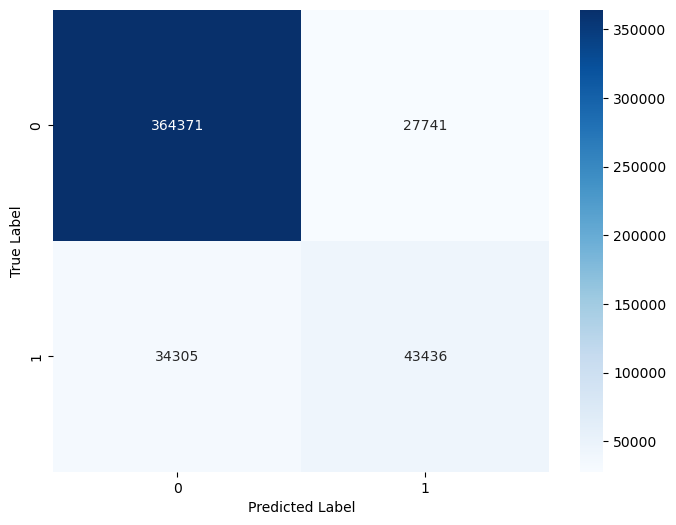

In [24]:
# Plot the confusion matrix for better visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Analysis Results

In [25]:
#Predict for the test data and merge the predicted values with the original data
data_test=data.loc[test_seq_index,:].copy()
y_pred = best_LSTM_model.predict(X_test_sequences).astype(int)
data_test['y_pred'] = y_pred

14683/14683 [==============================] - 95s 6ms/step


### Accuracy vs number of bets

In [26]:
# Create a column of 0 and 1 if correctly predicted
data_test['pred_correct']=(data_test['y_pred']==data_test['high_net_worth'])

#Group the data by total number of bets and for each number of bets compute accuracy
accgroup = data_test.groupby('total_bets_until_now')['pred_correct'].mean()
accgroup=accgroup.reset_index()

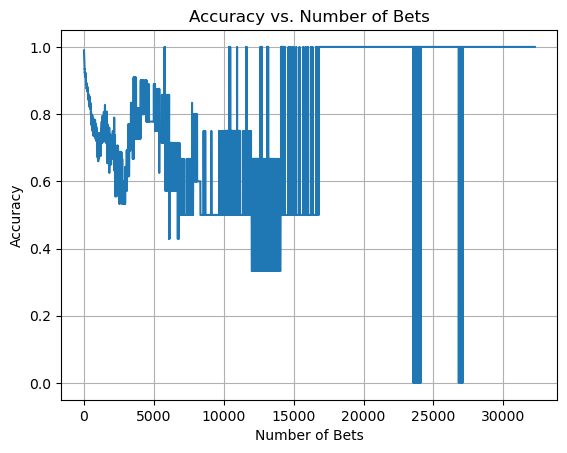

In [27]:
# Visualize accuracy against the number of bets
plt.plot(accgroup['total_bets_until_now'], accgroup['pred_correct'])
plt.xlabel('Number of Bets')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Bets')
plt.grid(True)
plt.show()

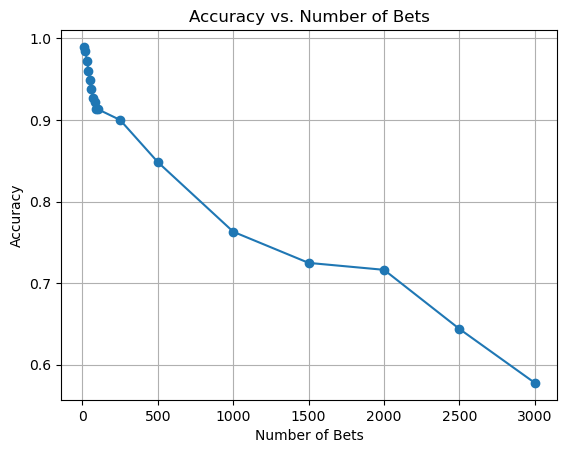

In [28]:
#Discretize the number of bets into bins and then visualize the 
#accuracy against the number of bets in each category

data_test['n_bets']=pd.cut(data_test['total_bets_until_now'],[0,10,20,30,40,50,60,70,80,90,100,250,500,1000,1500,2000,2500,3000],
                           labels=[10,20,30,40,50,60,70,80,90,100,250,500,1000,1500,2000,2500,3000])

accgroup2 = data_test.groupby('n_bets')['pred_correct'].mean()
accgroup2=accgroup2.reset_index()

# Visualize
plt.plot(accgroup2['n_bets'], accgroup2['pred_correct'],marker='o')
plt.xlabel('Number of Bets')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Bets')
#plt.xlim([0,100])
plt.grid(True)
plt.show()

### Precision vs number of bets

In [29]:
# Create columns for True Positives (TP), False Positives (FP) and False Negatives (FN)
data_test['TP'] = ((data_test['y_pred'] == 1) & (data_test['high_net_worth'] == 1)).astype(int)
data_test['FP'] = ((data_test['y_pred'] == 1) & (data_test['high_net_worth'] == 0)).astype(int)
data_test['FN'] = ((data_test['y_pred'] == 0) & (data_test['high_net_worth'] == 1)).astype(int)

#Group the data by total number of bets and for each number of bets compute TP and FP
prec_group = data_test.groupby('total_bets_until_now').agg({'TP': 'sum', 'FP': 'sum'})
prec_group=prec_group.reset_index()

In [30]:
# Compute precision for each group
prec_group['Precision'] = prec_group['TP'] / (prec_group['TP'] + prec_group['FP'])

# Handle NaN/Inf values if any (e.g., when both TP and FP are zero)
prec_group['Precision'].replace({np.inf: 0, np.nan: 0}, inplace=True)

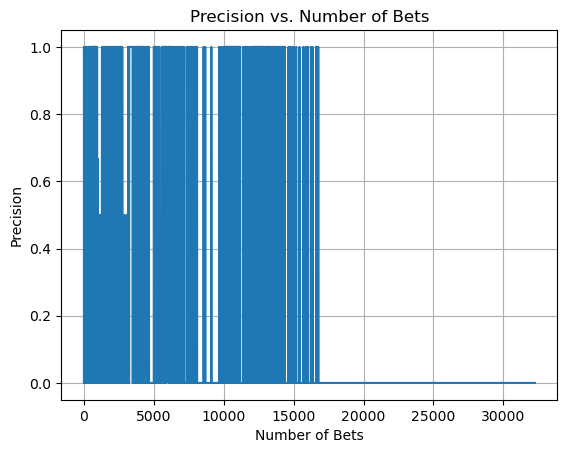

In [31]:
# Visualize precision against the number of bets
plt.plot(prec_group['total_bets_until_now'], prec_group['Precision'])
plt.xlabel('Number of Bets')
plt.ylabel('Precision')
plt.title('Precision vs. Number of Bets')
plt.grid(True)
plt.show()

/var/folders/yz/86sy0w0519d250z0rfq2qx5w0000gp/T/ipykernel_736/413561989.py:8: RuntimeWarning: invalid value encountered in long_scalars
  precision_group = data_test.groupby('n_bets').apply(lambda x: x['TP'].sum() / (x['TP'].sum() + x['FP'].sum())).reset_index()


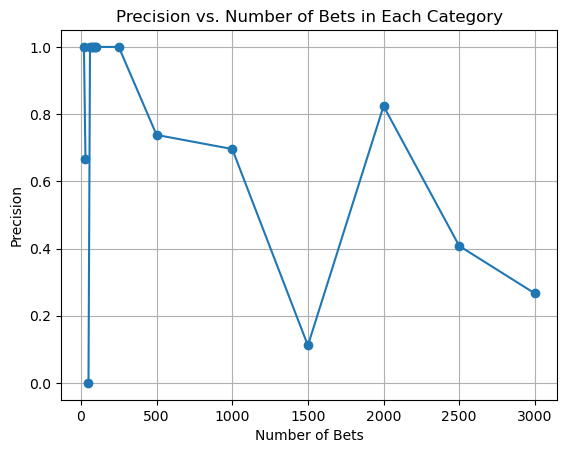

In [32]:
#Discretize the number of bets into bins and then visualize the 
#accuracy against the number of bets in each category

data_test['n_bets']=pd.cut(data_test['total_bets_until_now'],[0,10,20,30,40,50,60,70,80,90,100,250,500,1000,1500,2000,2500,3000],
                           labels=[10,20,30,40,50,60,70,80,90,100,250,500,1000,1500,2000,2500,3000])

# Group by number of bets category and compute precision
precision_group = data_test.groupby('n_bets').apply(lambda x: x['TP'].sum() / (x['TP'].sum() + x['FP'].sum())).reset_index()
precision_group.columns = ['n_bets', 'precision']

# Visualize
plt.plot(precision_group['n_bets'], precision_group['precision'], marker='o')
plt.xlabel('Number of Bets')
plt.ylabel('Precision')
plt.title('Precision vs. Number of Bets in Each Category')
plt.grid(True)
plt.show()                

### Recall vs number of bets

In [33]:
# Group by total number of bets and compute recall
recall_group = data_test.groupby('total_bets_until_now').apply(lambda x: x['TP'].sum() / (x['TP'].sum() + x['FN'].sum())).reset_index()
recall_group.columns = ['total_bets_until_now', 'recall']

/var/folders/yz/86sy0w0519d250z0rfq2qx5w0000gp/T/ipykernel_736/3103329723.py:2: RuntimeWarning: invalid value encountered in long_scalars
  recall_group = data_test.groupby('total_bets_until_now').apply(lambda x: x['TP'].sum() / (x['TP'].sum() + x['FN'].sum())).reset_index()


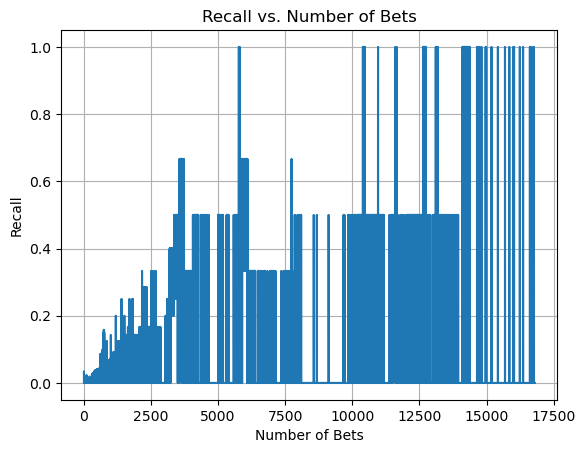

In [34]:
# Visualize recall against the number of bets
plt.plot(recall_group['total_bets_until_now'], recall_group['recall'])
plt.xlabel('Number of Bets')
plt.ylabel('Recall')
plt.title('Recall vs. Number of Bets')
plt.grid(True)
plt.show()

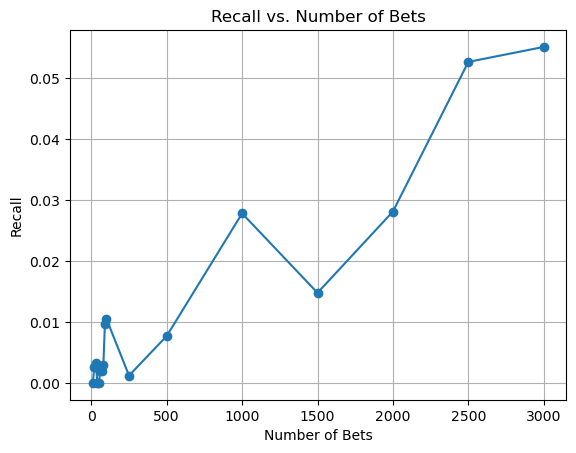

In [35]:
#Discretize the number of bets into bins and then visualize the 
#accuracy against the number of bets in each category

data_test['n_bets']=pd.cut(data_test['total_bets_until_now'],[0,10,20,30,40,50,60,70,80,90,100,250,500,1000,1500,2000,2500,3000],
                           labels=[10,20,30,40,50,60,70,80,90,100,250,500,1000,1500,2000,2500,3000])

# Group by the number of bets bin and compute recall for each bin
recall_group2 = data_test.groupby('n_bets').apply(lambda x: x['TP'].sum() / (x['TP'].sum() + x['FN'].sum())).reset_index()
recall_group2.columns = ['n_bets', 'recall']

# Visualize recall against the number of bets for each bin
plt.plot(recall_group2['n_bets'], recall_group2['recall'], marker='o')
plt.xlabel('Number of Bets')
plt.ylabel('Recall')
plt.title('Recall vs. Number of Bets')
plt.grid(True)
plt.show()
                             

### Proportion of HNW

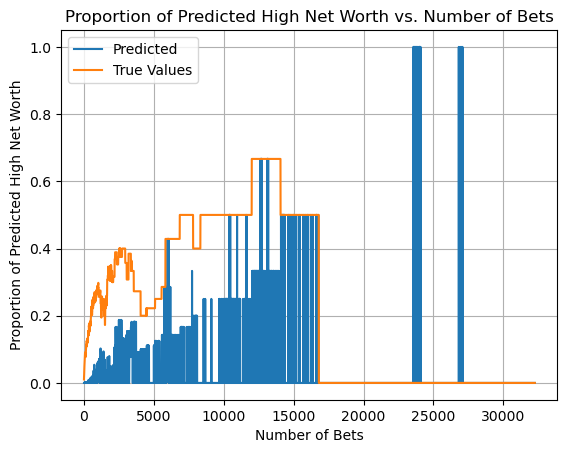

In [36]:
# create proportion of true and predicted high_net_worth for each number of bets and then visualize

predgroup = data_test.groupby('total_bets_until_now')[['high_net_worth','y_pred']].mean()
predgroup = predgroup.reset_index()

# Visualize
plt.plot(predgroup['total_bets_until_now'], predgroup['y_pred'],label='Predicted')
plt.plot(predgroup['total_bets_until_now'], predgroup['high_net_worth'],label='True Values')
plt.xlabel('Number of Bets')
plt.ylabel('Proportion of Predicted High Net Worth')
plt.title('Proportion of Predicted High Net Worth vs. Number of Bets')
plt.legend()
plt.grid(True)
plt.show()

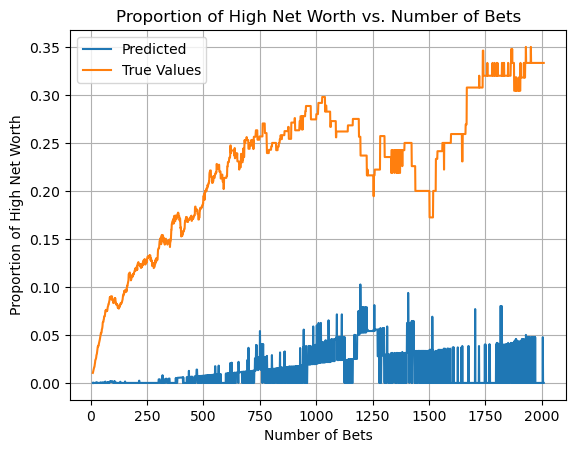

In [37]:
# Visualize the same as above when number of bets is upto 2000.
plt.plot(predgroup['total_bets_until_now'][:2000], predgroup['y_pred'][:2000],label='Predicted')
plt.plot(predgroup['total_bets_until_now'][:2000], predgroup['high_net_worth'][:2000],label='True Values')
plt.xlabel('Number of Bets')
plt.ylabel('Proportion of High Net Worth')
plt.title('Proportion of High Net Worth vs. Number of Bets')
plt.legend()
plt.grid(True)
plt.show()

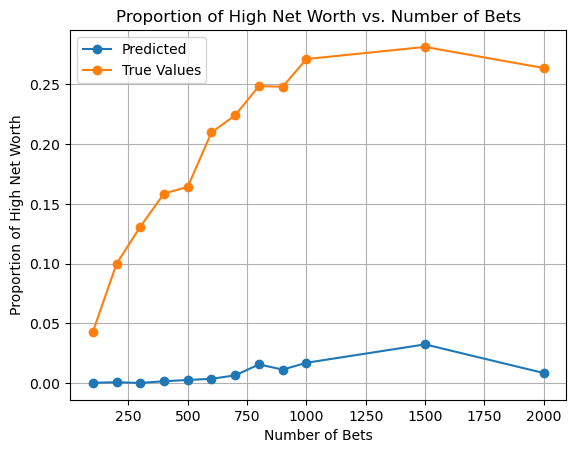

In [38]:
# create proportion of true and predicted high_net_worth for each number of bets and user and then visualize

data_test['n_bets']=pd.cut(data_test['total_bets_until_now'],[0,100,200,300,400,500,600,700,800,900,1000,1500, 2000],
                           labels=[100,200,300,400,500,600,700,800,900,1000,1500,2000])
predgroup2 = data_test.groupby(['encrypted_user_no','n_bets'])[['high_net_worth','y_pred']].mean()
predgroup2 = predgroup2.reset_index()
predgroup3 = predgroup2.groupby(['n_bets'])[['high_net_worth','y_pred']].mean()
predgroup3 = predgroup3.reset_index()

# Visualize
#predgroup2.plot.bar('n_bets', ['high_net_worth','y_pred'])
plt.plot(predgroup3['n_bets'], predgroup3['y_pred'],marker='o',label='Predicted')
plt.plot(predgroup3['n_bets'], predgroup3['high_net_worth'],marker='o', label='True Values')
plt.xlabel('Number of Bets')
plt.ylabel('Proportion of High Net Worth')
plt.title('Proportion of High Net Worth vs. Number of Bets')
plt.legend()
plt.grid(True)
plt.show()

### Num bets before label change

In [39]:
#Bets before change for each user
data_test = data_test.sort_values(['encrypted_user_no','total_bets_until_now'])
data_test['y_diffs'] = data_test['high_net_worth'].diff()
data_test['ypred_diffs'] = data_test['y_pred'].diff()

mask = (data_test['encrypted_user_no'] != data_test['encrypted_user_no'].shift(1) )
data_test.loc[mask,'y_diffs'] = np.nan
data_test.loc[mask,'ypred_diffs'] = np.nan

bet_changey=data_test.index[np.where(data_test.y_diffs==1)[0]]
bet_changeyp=data_test.index[np.where(data_test.ypred_diffs==1)[0]]


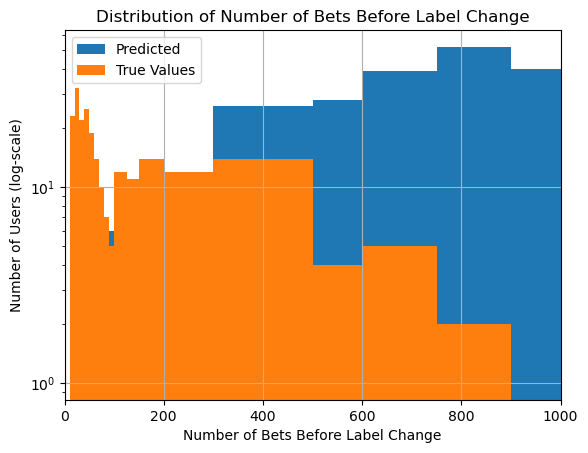

In [40]:
# Visualize
bins = [0,10,20,30,40,50,60,70,80,90,100,125, 150, 200,300,500,600,750,900,1000]
ax=data_test.loc[bet_changeyp,:].hist('total_bets_until_now',bins=bins,label='Predicted')
data_test.loc[bet_changey,:].hist('total_bets_until_now',bins=bins,ax=ax,label='True Values')

plt.xlim([0,1000])
# Labels and title
plt.yscale('log')
plt.xlabel('Number of Bets Before Label Change')
plt.ylabel('Number of Users (log-scale)')
plt.title('Distribution of Number of Bets Before Label Change')
plt.legend()
plt.grid(True)
plt.show()

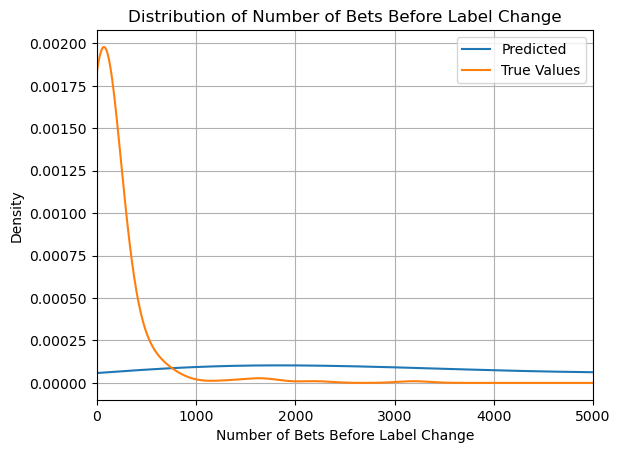

In [41]:
ax=data_test.loc[bet_changeyp,'total_bets_until_now'].plot.density(label='Predicted')
data_test.loc[bet_changey,'total_bets_until_now'].plot.density(ax=ax,label='True Values')

plt.xlim([0,5000])
plt.xlabel('Number of Bets Before Label Change')
plt.ylabel('Density')
plt.title('Distribution of Number of Bets Before Label Change')
plt.legend()
plt.grid(True)
plt.show()